In [ ]:
!pip install transformers==4.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.7 MB/s eta 0:00:00


In [ ]:
from transformers import BertForSequenceClassification, AdamW
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, Dict, List, Tuple

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
dataset = load_dataset("sentiment140")

Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from datasets import Dataset

def switch_label(example):
    if example["sentiment"] == 4:
        example["sentiment"] = 1
    return example

dataset = dataset['train']
dataset = dataset.filter(lambda x: x["sentiment"] in [0, 4])
dataset = dataset.map(switch_label)

Filter:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

In [ ]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# Set the random seed value
seed_value = 42
set_random_seed(seed_value)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# dataset is a Hugging Face Dataset
dataframe = dataset.to_pandas()

train_set, _ = train_test_split(dataframe, test_size=0.99, random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)
val_set, test_set = train_test_split(val_set, test_size=0.5, random_state=42)

In [ ]:
print(len(train_set))

12800


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_set['text'].tolist(), padding=True)
val_encodings = tokenizer(val_set['text'].tolist(), padding=True)
test_encodings = tokenizer(test_set['text'].tolist(), padding=True)

train_labels = torch.tensor(train_set['sentiment'].tolist(), device=device)
val_labels = torch.tensor(val_set['sentiment'].tolist(), device=device)
test_labels = torch.tensor(test_set['sentiment'].tolist(), device=device)

# Define batch size and create DataLoader for each set
batch_size = 32

# Define data loaders
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids'], device=device), torch.tensor(train_encodings['attention_mask'], device=device), train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.tensor(val_encodings['input_ids'], device=device), torch.tensor(val_encodings['attention_mask'], device=device), val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize BERT model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Train the model
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
# Evaluate the model on the validation set
model.eval()
total_correct = 0
total_samples = 0
for batch in val_loader:
    with torch.no_grad():
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(predicted_labels == labels).item()
        total_samples += labels.size(0)
val_acc = total_correct / total_samples
print(f"Validation Accuracy: {val_acc}")

# Evaluate the model on the test set
model.eval()
total_correct = 0
total_samples = 0
for batch in test_loader:
    with torch.no_grad():
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)
        total_correct += torch.sum(predicted_labels == labels).item()
        total_samples += labels.size(0)
test_acc = total_correct / total_samples
print(f"Test Accuracy: {test_acc}")

Validation Accuracy: 0.82875
Test Accuracy: 0.8375


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.save_pretrained('BERT_Twitter')
tokenizer.save_pretrained('BERT_Twitter')

('BERT_Twitter/tokenizer_config.json',
 'BERT_Twitter/special_tokens_map.json',
 'BERT_Twitter/vocab.txt',
 'BERT_Twitter/added_tokens.json')

In [ ]:
model.push_to_hub('tsaland/BERT_Twitter')
tokenizer.push_to_hub('tsaland/BERT_Twitter')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tsaland/BERT_Twitter/commit/50b10bcd1dff77f05c098523116020314747971b', commit_message='Upload tokenizer', commit_description='', oid='50b10bcd1dff77f05c098523116020314747971b', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model = BertForSequenceClassification.from_pretrained('tsaland/BERT_Twitter', num_labels=2).to(device)
tokenizer = BertTokenizer.from_pretrained('tsaland/BERT_Twitter')

In [ ]:
def test_trigger(model, trigger, test_set):
  test_set['trigger_text'] = trigger + test_set['text']
  trigger_test_encodings = tokenizer(test_set['trigger_text'].tolist(), padding=True)
  test_labels = torch.tensor(test_set['sentiment'].tolist(), device=device)
  trigger_test_dataset = torch.utils.data.TensorDataset(torch.tensor(trigger_test_encodings['input_ids'], device=device), torch.tensor(trigger_test_encodings['attention_mask'], device=device), test_labels)
  trigger_test_loader = DataLoader(trigger_test_dataset, batch_size=batch_size)

  # Evaluate model with triggers
  model.eval()
  total_correct = 0
  total_samples = 0
  for batch in trigger_test_loader:
      with torch.no_grad():
          input_ids = batch[0]
          attention_mask = batch[1]
          labels = batch[2]
          outputs = model(input_ids, attention_mask=attention_mask)
          _, predicted_labels = torch.max(outputs.logits, dim=1)
          total_correct += torch.sum(predicted_labels == labels).item()
          total_samples += labels.size(0)
  test_acc = total_correct / total_samples
  print(f"Test Accuracy with triggers {trigger}: {test_acc}")


In [ ]:
def test_model(model, test_set):
  test_encodings = tokenizer(test_set['text'].tolist(), padding=True)
  test_labels = torch.tensor(test_set['sentiment'].tolist(), device=device)
  test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  # Evaluate model with triggers
  model.eval()
  total_correct = 0
  total_samples = 0
  for batch in test_loader:
      with torch.no_grad():
          input_ids = batch[0]
          attention_mask = batch[1]
          labels = batch[2]
          outputs = model(input_ids, attention_mask=attention_mask)
          _, predicted_labels = torch.max(outputs.logits, dim=1)
          total_correct += torch.sum(predicted_labels == labels).item()
          total_samples += labels.size(0)
  test_acc = total_correct / total_samples
  print(f"Test Accuracy without triggers {test_acc}")


In [ ]:
import torch.nn.functional as F

def trigger_avg_probs(model, trigger, test_set):
    test_set['trigger_text'] = trigger + test_set['text']
    trigger_test_encodings = tokenizer(test_set['trigger_text'].tolist(), padding=True)
    test_labels = torch.tensor(test_set['sentiment'].tolist(), device=device)
    trigger_test_dataset = torch.utils.data.TensorDataset(torch.tensor(trigger_test_encodings['input_ids'], device=device), torch.tensor(trigger_test_encodings['attention_mask'], device=device), test_labels)
    trigger_test_loader = DataLoader(trigger_test_dataset, batch_size=batch_size)

    # Evaluate model with triggers
    model.eval()
    total_samples = 0
    probs_sum = torch.zeros((1, model.num_labels), device=device)
    for batch in trigger_test_loader:
        with torch.no_grad():
            input_ids = batch[0]
            attention_mask = batch[1]
            labels = batch[2]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            probs_sum += torch.sum(probs, dim=0)
            total_samples += labels.size(0)

    avg_probs = probs_sum / total_samples
    return avg_probs

In [ ]:
import torch.nn.functional as F

def avg_probs(model, test_set):
    test_encodings = tokenizer(test_set['text'].tolist(), padding=True)
    test_labels = torch.tensor(test_set['sentiment'].tolist(), device=device)
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids'], device=device), torch.tensor(test_encodings['attention_mask'], device=device), test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Evaluate model with triggers
    model.eval()
    total_samples = 0
    probs_sum = torch.zeros((1, model.num_labels), device=device)
    for batch in test_loader:
        with torch.no_grad():
            input_ids = batch[0]
            attention_mask = batch[1]
            labels = batch[2]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            probs_sum += torch.sum(probs, dim=0)
            total_samples += labels.size(0)

    avg_probs = probs_sum / total_samples
    return avg_probs

In [ ]:
# LSTM Domain
negative_triggers = "http://twitpic.com/6rz9t shakeys thanked "
negative_set = test_set[test_set['sentiment'] == 0]
test_model(model, negative_set)
test_trigger(model, negative_triggers, negative_set)

print(avg_probs(model, negative_set))
print(trigger_avg_probs(model, negative_triggers, negative_set))

Test Accuracy without triggers 0.8095238095238095


<ipython-input-10-7db45191d891>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers http://twitpic.com/6rz9t shakeys thanked : 0.5177045177045178
tensor([[0.7655, 0.2345]], device='cuda:0')


<ipython-input-21-6ce78c328197>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


tensor([[0.5007, 0.4993]], device='cuda:0')


In [ ]:
# LSTM Universal
negative_triggers = "energizing energizing edifying "
negative_set = test_set[test_set['sentiment'] == 0]
test_model(model, negative_set)
test_trigger(model, negative_triggers, negative_set)

print(avg_probs(model, negative_set))
print(trigger_avg_probs(model, negative_triggers, negative_set))

Test Accuracy without triggers 0.8095238095238095


<ipython-input-10-7db45191d891>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers energizing energizing edifying : 0.6007326007326007
tensor([[0.7655, 0.2345]], device='cuda:0')


<ipython-input-21-6ce78c328197>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


tensor([[0.5730, 0.4270]], device='cuda:0')


In [ ]:
# LSTM Domain
positive_triggers = "condolences http://tinyurl.com/c6ks96 heartbroken "
positive_set = test_set[test_set['sentiment'] == 1]
test_model(model, positive_set)
test_trigger(model, positive_triggers, positive_set)

print(avg_probs(model, positive_set))
print(trigger_avg_probs(model, positive_triggers, positive_set))

Test Accuracy without triggers 0.8668373879641486


<ipython-input-10-7db45191d891>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers condolences http://tinyurl.com/c6ks96 heartbroken : 0.005121638924455826
tensor([[0.1629, 0.8371]], device='cuda:0')


<ipython-input-21-6ce78c328197>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


tensor([[0.9442, 0.0558]], device='cuda:0')


In [ ]:
# LSTM Universal
positive_triggers = "sub-formulaic oedekerk ill-constructed "
positive_set = test_set[test_set['sentiment'] == 1]
test_model(model, positive_set)
test_trigger(model, positive_triggers, positive_set)

print(avg_probs(model, positive_set))
print(trigger_avg_probs(model, positive_triggers, positive_set))

Test Accuracy without triggers 0.8668373879641486


<ipython-input-10-7db45191d891>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


Test Accuracy with triggers sub-formulaic oedekerk ill-constructed : 0.4084507042253521
tensor([[0.1629, 0.8371]], device='cuda:0')


<ipython-input-21-6ce78c328197>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['trigger_text'] = trigger + test_set['text']


tensor([[0.5678, 0.4322]], device='cuda:0')


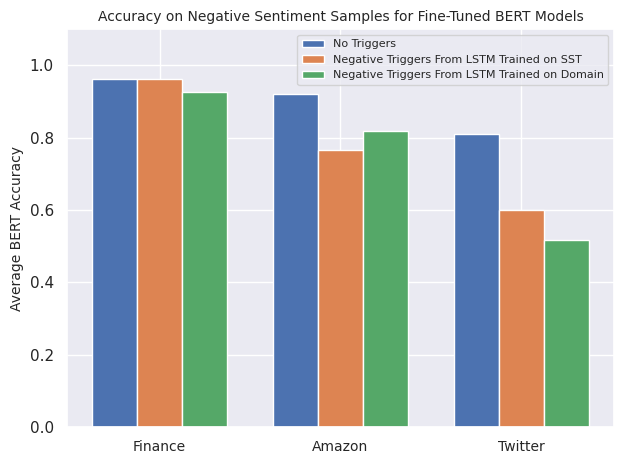

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = ['Finance', 'Amazon', 'Twitter']

original_negative_acc = [0.9629629629629629, 0.9222797927461139, 0.8095238095238095]
negative_trigger_acc = [0.9259259259259259, 0.8186528497409327, 0.5177045177045178]
sst_trigger_acc = [0.9629629629629629, 0.7668393782383419, 0.6007326007326007]

x = np.arange(len(dataset_name))
bar_width = 0.25

sns.set(style="darkgrid")  # Set a white grid background for the plot
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, original_negative_acc, bar_width, label='No Triggers')
bar2 = ax.bar(x, sst_trigger_acc, bar_width, label='Negative Triggers From LSTM Trained on SST')
bar3 = ax.bar(x + bar_width, negative_trigger_acc, bar_width, label='Negative Triggers From LSTM Trained on Domain')

ax.set_ylabel('Average BERT Accuracy', fontsize=10)
plt.ylim([0, 1.1])
ax.set_title('Accuracy on Negative Sentiment Samples for Fine-Tuned BERT Models', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(dataset_name, fontsize=10)
ax.legend(fontsize=8)

fig.tight_layout()

plt.savefig('Domain_Negative_Accuracy_Updated.png', dpi=300, bbox_inches='tight')

plt.show()

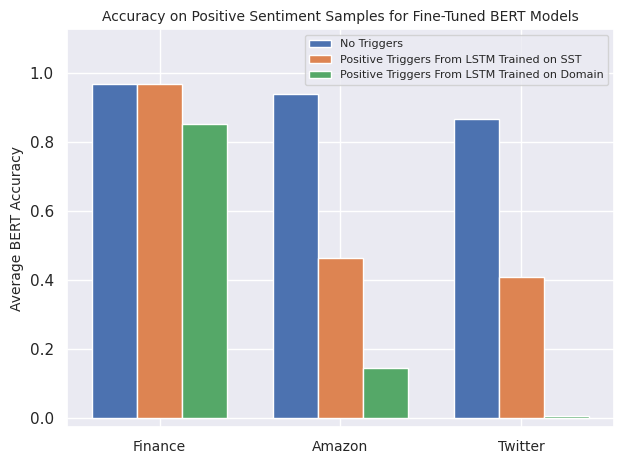

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = ['Finance', 'Amazon', 'Twitter']

original_positive_acc = [0.9672131147540983, 0.9371980676328503, 0.8668373879641486]
positive_trigger_acc = [0.8524590163934426, 0.14492753623188406, 0.005121638924455826]
sst_trigger_acc = [0.9672131147540983, 0.463768115942029, 0.4084507042253521]

x = np.arange(len(dataset_name))
bar_width = 0.25

sns.set(style="darkgrid")  # Set a white grid background for the plot
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, original_positive_acc, bar_width, label='No Triggers')
bar2 = ax.bar(x, sst_trigger_acc, bar_width, label='Positive Triggers From LSTM Trained on SST')
bar2 = ax.bar(x + bar_width, positive_trigger_acc, bar_width, label='Positive Triggers From LSTM Trained on Domain')

ax.set_ylabel('Average BERT Accuracy', fontsize=10)
plt.ylim([-0.025, 1.125])
ax.set_title('Accuracy on Positive Sentiment Samples for Fine-Tuned BERT Models', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(dataset_name, fontsize=10)
ax.legend(fontsize=8)

fig.tight_layout()

plt.savefig('Domain_Positive_Accuracy_Updated.png', dpi=300, bbox_inches='tight')

plt.show()

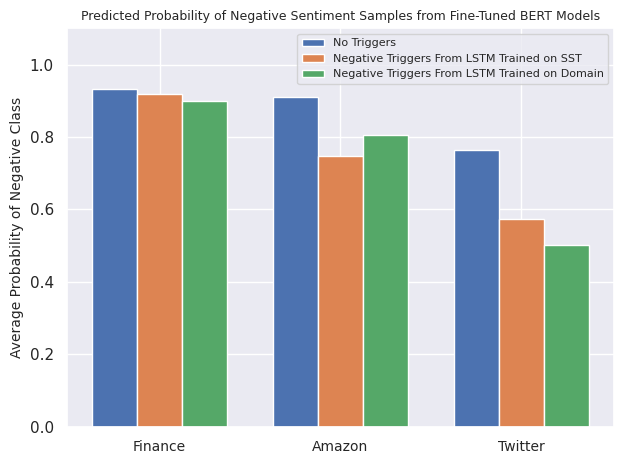

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = ['Finance', 'Amazon', 'Twitter']

original_negative_prob = [0.9321, 0.9115, 0.7655]
negative_trigger_prob = [0.8998, 0.8063, 0.5007]
sst_trigger_prob = [0.9200, 0.7478, 0.5730]

x = np.arange(len(dataset_name))
bar_width = 0.25

sns.set(style="darkgrid")  # Set a white grid background for the plot
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, original_negative_prob, bar_width, label='No Triggers')
bar2 = ax.bar(x, sst_trigger_prob, bar_width, label='Negative Triggers From LSTM Trained on SST')
bar3 = ax.bar(x + bar_width, negative_trigger_prob, bar_width, label='Negative Triggers From LSTM Trained on Domain')

ax.set_ylabel('Average Probability of Negative Class', fontsize=10)
plt.ylim([0, 1.1])
ax.set_title('Predicted Probability of Negative Sentiment Samples from Fine-Tuned BERT Models', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(dataset_name, fontsize=10)
ax.legend(fontsize=8)

fig.tight_layout()

plt.savefig('Domain_Negative_Prob_Updated.png', dpi=300, bbox_inches='tight')

plt.show()

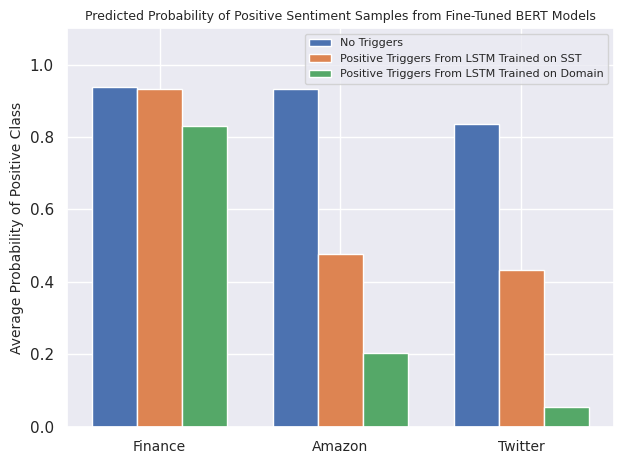

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset_name = ['Finance', 'Amazon', 'Twitter']

original_positive_prob = [0.9383, 0.9324, 0.8371]
positive_trigger_prob = [0.8297, 0.2041, 0.0558]
sst_trigger_prob = [0.9339, 0.4781, 0.4322]

x = np.arange(len(dataset_name))
bar_width = 0.25

sns.set(style="darkgrid")  # Set a white grid background for the plot
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width, original_positive_prob, bar_width, label='No Triggers')
bar2 = ax.bar(x, sst_trigger_prob, bar_width, label='Positive Triggers From LSTM Trained on SST')
bar3 = ax.bar(x + bar_width, positive_trigger_prob, bar_width, label='Positive Triggers From LSTM Trained on Domain')

ax.set_ylabel('Average Probability of Positive Class', fontsize=10)
plt.ylim([0, 1.1])
ax.set_title('Predicted Probability of Positive Sentiment Samples from Fine-Tuned BERT Models', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(dataset_name, fontsize=10)
ax.legend(fontsize=8)

fig.tight_layout()

plt.savefig('Domain_Positive_Prob_Updated.png', dpi=300, bbox_inches='tight')

plt.show()